In [119]:
import lenet
import importlib
importlib.reload(lenet)
from lenet import Lenet
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import copy

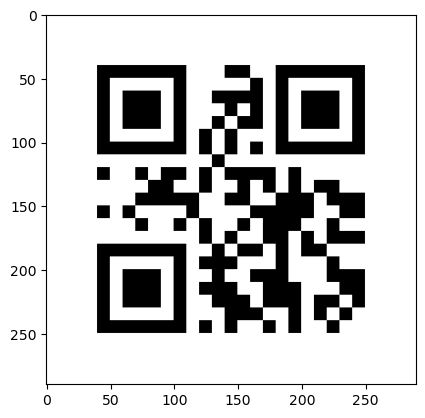

In [120]:
datadir = "./datasets/qr_dataset/"
for img in os.listdir(datadir):
    img_array = cv2.imread(os.path.join(datadir, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break

In [121]:
class ImageDataset(Dataset):
  def __init__(self,img_dir,df,transforms1=None):
    self.image_dir=img_dir
    self.transforms=transforms1
    self.df=df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
    image=Image.open(self.image_dir+self.df.iloc[index][0])
    label=int(self.df.iloc[index][1])
    if self.transforms:
      image=self.transforms(image)
      
    return image,torch.tensor(label)
  

In [122]:
label1=os.listdir('./datasets/qr_dataset/')
dataf=pd.DataFrame()
file_n=[]
label_=[]
for i in label1:
  file_name=i
  label=i.replace('.png','').split('-v')[1]
  file_n.append(file_name)
  label_.append(label)
  
  #print('file_name',file_name,'label',label)
  
final_dataframe=pd.DataFrame({'name':file_n, 'label':label_})
final_dataframe.iloc[0][0]

'8978-v1.png'

In [123]:
datadir = "./datasets/qr_dataset/"
data_transfrom = transforms.Compose([ 
    transforms.Resize((28, 28)),     
    transforms.ToTensor(),            
])
image_set=ImageDataset(datadir,final_dataframe,data_transfrom)

In [124]:
image_set.__len__()

10000

In [125]:
train_data,test_data=train_test_split(image_set,test_size=0.2,shuffle=True)

In [126]:
train_loader=DataLoader(dataset=train_data,batch_size=64,shuffle=True,num_workers=0)
test_loader=DataLoader(dataset=test_data,batch_size=64,shuffle=True,num_workers=0)


In [133]:
def train(model, train_loader, epoches):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimize = torch.optim.SGD(params=model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    for epoch in range(epoches):
        print("epoch", epoch)
        print("--" * 20)
        train_acc = 0.0
        train_loss = 0.0
        train_num = 0
        for batch, (feature, label) in enumerate(train_loader):
            feature = feature.to(device)
            label = label.to(device)
            model.train()
            prob = model(feature)
            loss = criterion(prob, label)
            optimize.zero_grad()
            loss.backward()
            optimize.step()
            train_loss += loss.item() * feature.size(0)
            pre_label = torch.argmax(prob, dim=1)
            train_acc += torch.sum(pre_label == label)
            train_num += feature.size(0)
            if batch % 100 == 0:
                print(f"loss:{loss:.4f}")
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_acc.double().item() / train_num)
        print(
            "{} train_loss:{:.4f} train_acc:{:.4f}".format(
                epoch, train_loss_all[-1], train_acc_all[-1]
            )
        )

        if train_acc_all[-1] > best_acc:
            best_acc = train_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())

        torch.save(best_model_wts, f"./best_model.pth")
        print("train_loss", train_loss_all.shape)
        print("train_acc", train_acc_all.shape)
    train_process = pd.DataFrame(
        {
            "epoch": range(epoches),
            "train_acc": train_acc_all,
            "train_loss": train_loss_all,
        }
    )

    return train_process

In [132]:
if __name__=="__main__":
  model=Lenet()
  epoches=3
  train_process=train(model,train_loader,epoches)

epoch 0
----------------------------------------
loss:2.3086
loss:2.2808
0 train_loss:2.2901 train_acc:0.0018


ValueError: All arrays must be of the same length

In [ ]:
def 